# Large Reservoir Randomized High order FCM for univariate time series prediction

* Omid Orang  <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0002-4077-3775" href="https://orcid.org/0000-0002-4077-3775" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>
* Fabricio J. E. Costa
* Petrônio C.  L. Silva  <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0002-1202-2552" href="https://orcid.org/0000-0002-1202-2552" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>
* Frederico G. Guimarães <span itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0001-9238-8839" href="https://orcid.org/0000-0001-9238-8839" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="https://orcid.org/sites/default/files/images/orcid_16x16.png" style="width:1em;margin-right:.5em;" alt="ORCID iD icon"></a></span>

In case you have any questions, do not hesitate in contact us using the following e-mail: omid.orang2009@gmail.com

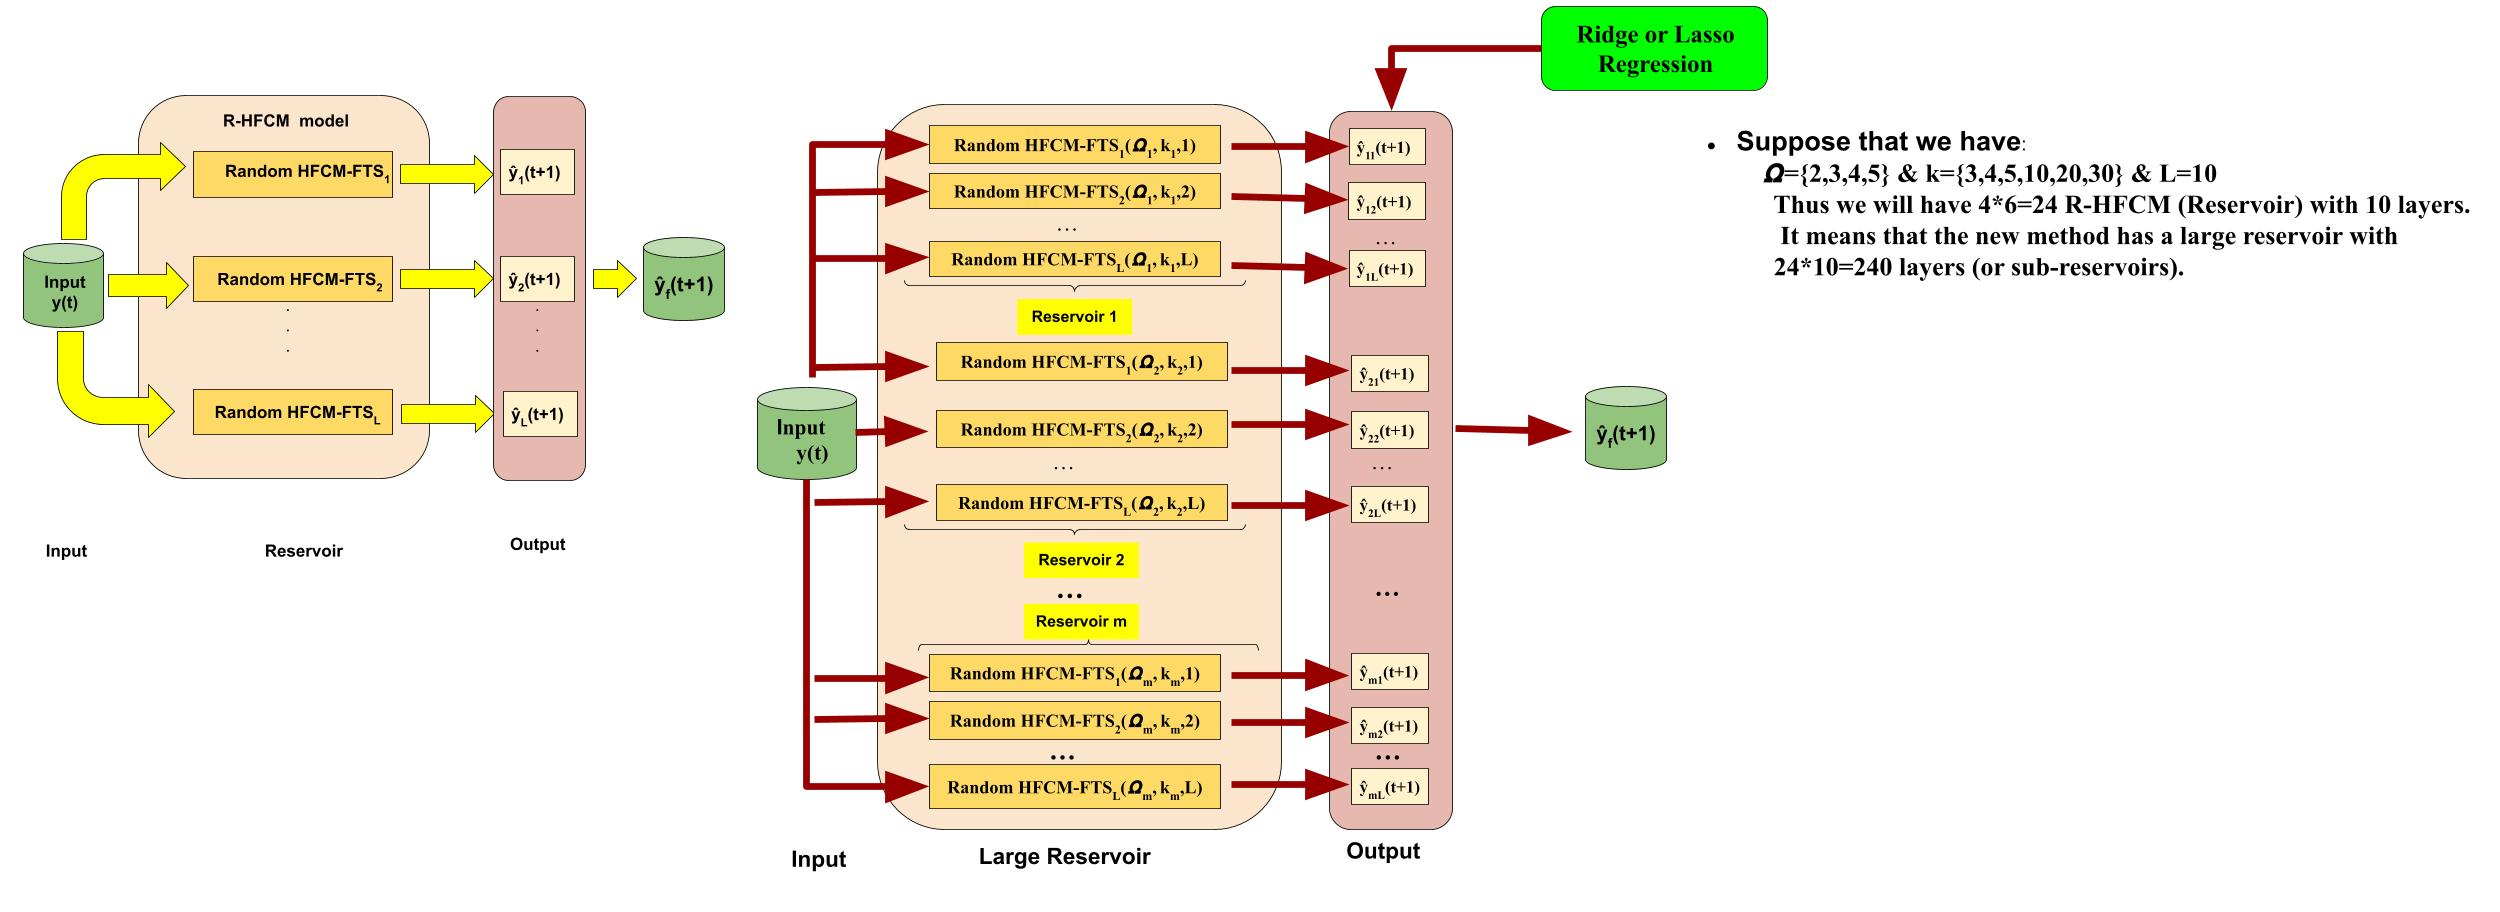




In [ ]:
!pip3 install -U git+https://github.com/PYFTS/pyFTS

  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-0333cors
  Running command git clone --filter=blob:none --quiet https://github.com/PYFTS/pyFTS /tmp/pip-req-build-0333cors
  Resolved https://github.com/PYFTS/pyFTS to commit 4e0ee7cdd9fc9a8ac9170c0c3496536ef0378cb7
  Preparing metadata (setup.py) ... done
  Created wheel for pyFTS: filename=pyFTS-1.7-py3-none-any.whl size=219432 sha256=430175122b10b70c7ab791ae0891da37433d7069fbb4652601f0d9997f42b8c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-b_pfr6o2/wheels/7f/25/75/dd8f713bf48592da71e0441c7abdc1f5aa4d9645a6b7ee99d4
Successfully built pyFTS


In [ ]:
# Importing libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from math import e,sqrt
from pyFTS.fcm import Activations
from pyFTS.models import hofts
from numpy.linalg import svd
from pyFTS.fcm import fts as fcm_fts
from pyFTS.partitioners import Grid
from pyFTS.common import Util
from pyFTS.common import Membership as mf
from scipy.optimize import least_squares
from scipy.optimize import leastsq
from pyFTS.benchmarks import Measures
import math
import pdb
import math
from pyFTS.benchmarks import Measures
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


/usr/local/lib/python3.10/dist-packages/pyFTS/common/transformations/trend.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [ ]:
#defining FCM
class FuzzyCognitiveMap(object):
    def __init__(self, **kwargs):
        super(FuzzyCognitiveMap, self).__init__()
        self.order = kwargs.get('order',1)
        self.concepts = kwargs.get('partitioner',None)
        self.weights = []
        self.bias=[]
        self.activation_function = kwargs.get('activation_function', Activations.sigmoid)
        #self.activation_function=softplus

        #self.concepts = self.partitioner


    def activate(self, memberships):
        dot_products = np.zeros(len(self.concepts))
        for k in np.arange(0, self.order):
            dot_products += np.dot(np.array(memberships[k]).T, self.weights[k])+(self.bias[k])
        return self.activation_function( dot_products )


In [ ]:
# Function for the last layer for least squares
def func(values, *arg):

    # values -> predicted values

    #print(values.shape)
    if len(values.shape) == 1:
      n_coefs = values.shape[0] + 1
      #return arg[0] + np.sum([values[i-1] * arg[i] for i in np.arange(1,n_coefs)])
      ret = 0
    else:
      n_coefs = values.shape[0] + 1
      n_inst = values.shape[1]
      ret = np.zeros(n_inst)
    for k in range(1, n_coefs):
      ret = ret + arg[k] * values[k-1]

    ret = ret + arg[0]

    return ret

In [ ]:
#%%debug
# RHFCM Model
class FCM_FTS(hofts.HighOrderFTS):

    def __init__(self, **kwargs):
        super(FCM_FTS, self).__init__(**kwargs)


        num_concepts = self.partitioner.partitions # Number of concepts

        self.num_concepts = kwargs.get('num_concepts', 4)

        self.num_fcms = kwargs.get('num_fcms', 2)   # The number of sub-reservoir (layers)

        self.loss_function = kwargs.get('loss', func) # Loss function for OLS method

        self.orderMax = kwargs.get('orderMax', 4)

        #print(self.orderMax)

        #self.partitioner = kwargs.get('partitioner',Grid.GridPartitioner(data=data, npart=self.num_concepts, mf=mf.trimf))

        #self.partitioner = Grid.GridPartitioner(data=data, npart=self.num_concepts, mf=mf.trimf)

        #print(self.partitioner)

        #print(self.orderMax)


        self.fcm = [] # Initialization of fcm (empty)

        # Weight initialization
        for k in range(self.num_fcms):
          # np.random.seed(42+10*k+200)     # HERE
          fcm_tmp = FuzzyCognitiveMap(**kwargs)
          weights = np.random.uniform(-1, 1, size=(self.order,num_concepts, num_concepts))
          specturalradius1=np.max(np.abs(np.linalg.eigvals(weights)))
          fcm_tmp.weights = weights*0.5/specturalradius1
          # np.random.seed(35+10*k+200)     # HERE
          bias = np.random.uniform(-1, 1, size=(self.order,num_concepts))
          U,S,VT=svd(bias) # Not square
          specturalradius2=np.max(S)
          fcm_tmp.bias=bias*0.5/specturalradius2    # epsilon = 0.5
          self.fcm.append(fcm_tmp)


        # Coefficients
        self.theta = np.random.rand(self.num_fcms + 1) # Initialization for least squares


    def forecast(self, data, **kwargs):
        y1 = []

        midpoints = np.array([fset.centroid for fset in self.partitioner])


        #if self.order == 3:
        #  pdb.set_trace()
        #print('Number of layers: ')
        #print(type(self.fcm))
        #print(np.shape(self.fcm))
        #print(self.fcm[0].weights)
        #print(self.fcm[0].concepts)


        #for t in np.arange(self.order, len(data)+1):   # Sweeping all data points depending of the order ------ CHANGE VARIABLE HERE!!!!!!
        for t in np.arange(self.orderMax, len(data)+1):   # Sweeping all data points depending of the order ------ CHANGE VARIABLE HERE!!!!!!

            sample = data[t - self.order : t]

            fuzzyfied = self.partitioner.fuzzyfy(sample, mode='vector')

            # Evaluate FCMs

            forecasts = []

            for fcm in self.fcm:
              activation=fcm.activate(fuzzyfied)
              forecasts.append(np.dot(midpoints, activation)/np.nanmax([1, np.sum(activation)]))    # Forecasting

            # Combine the results

            #print(forecasts)

            result = self.loss_function(np.array(forecasts), *self.theta)

            if str(result) == 'nan' or result == np.nan or result == np.Inf:
               print('error')

            y1.append(result)

        return y1

    def run_fcm(self, fcm, data):
        ret = []

        midpoints = np.array([fset.centroid for fset in self.partitioner])
        #for t in np.arange(self.order, len(data)+1):   # Sweeping all data points. ------ CHANGE VARIABLE HERE!!!!!!
        for t in np.arange(self.orderMax, len(data)+1):   # Sweeping all data points. ------ CHANGE VARIABLE HERE!!!!!!
            sample = data[t - self.order : t]
            fuzzyfied = self.partitioner.fuzzyfy(sample, mode='vector')
            activation = fcm.activate(fuzzyfied)
            final = np.dot(midpoints, activation)/np.nanmax([1, np.sum(activation)])
            ret.append(final)
        return ret

    def outputEstimation(self, data, **kwargs):
        #from scipy.optimize import curve_fit, least_squares, minimize, leastsq
        from scipy.optimize import leastsq
        from sklearn.linear_model import Ridge
        from sklearn import linear_model

        outputs = []

        for model in self.fcm:
          outputs.append(self.run_fcm(model, data)[:-1])
          #print(outputs)
        #OLS

        #f = lambda coef, y, x: self.loss_function(x, *coef) - y    # x -> output of the subreservoir

        # y -> real data
        # x -> predicted values

        #self.theta, flag = leastsq(f, x0 = self.theta, args=(data[self.order:], np.array(outputs)))
        #print('Coefs OLS')
        #print(self.theta)
        return outputs


In [ ]:
def trainRegression(data,outputs,orderMax, typeRegression):

  from scipy.optimize import leastsq
  from sklearn.linear_model import Ridge
  from sklearn import linear_model

  if typeRegression == 'Lasso':
    ##### Lasso
    from sklearn.linear_model import LassoCV

    ##### Lasso
    # Crossvalidation (Finding the best alpha)
    resultsCV = LassoCV(cv=5, random_state=0).fit(np.array(outputs).T, data[orderMax:])
    print(f'resultsCV.alpha_: {(resultsCV.alpha_)}')

    lassoModel = linear_model.Lasso(alpha=resultsCV.alpha_)

    lassoModel.fit(np.array(outputs).T, data[orderMax:])
    tetha = np.concatenate((np.array([lassoModel.intercept_]),lassoModel.coef_))


    # lassoModel = linear_model.Lasso(alpha=100000)
    # lassoModel.fit(np.array(outputs).T, data[orderMax:])
    # tetha = np.concatenate((np.array([lassoModel.intercept_]),lassoModel.coef_))

  if typeRegression == 'Ridge':
    ##### Ridge of regression
    clf = Ridge(alpha=.1)
    clf.fit(np.array(outputs).T, data[orderMax:])
    tetha = np.concatenate((np.array([clf.intercept_]),clf.coef_))

  return tetha

In [ ]:
def CalculateCoef(data, set_parts, set_orders, numLayers, orderMax):
  train = data.values[:1500]

  # train = df['load'].values[:6500]
  #test = df['load'].values[:6500]
  test = data.values[:500]
  estimated_outputs_train = []
  estimated_outputs_test=[]
  for ii in set_parts:
    for jj in set_orders:
      partitioner = Grid.GridPartitioner(data=data, npart=ii, mf=mf.trimf)
      model = FCM_FTS(partitioner=partitioner, order=jj, num_fcms=numLayers,
                  activation_function=Activations.sigmoid,
                  loss=func, orderMax=orderMax)

      aux_train=model.outputEstimation(train)
      aux_test=model.outputEstimation(test)
      estimated_outputs_train = estimated_outputs_train + aux_train

      estimated_outputs_test = estimated_outputs_test + aux_test

  return estimated_outputs_train, model,estimated_outputs_test

In [ ]:
# Malaysia load dataset
df=pd.read_csv('https://query.data.world/s/e5arbthdytod3m7wfcg7gmtluh3wa5', sep=';')
# data = df['load'].values[:8760]
data=df['load']


train = df['load'].values[:1500]

# # train = df['load'].values[:6500]
# #test = df['load'].values[:6500]
test = df['load'].values[:500]


# Hyperparameters
set_parts = [3,4,5,6]
set_orders = [2,3,4,5]
numLayers =40
orderMax = np.max(set_orders)

# model = []
#
estimated_outputs_train, model,estimated_outputs_test = CalculateCoef(data, set_parts, set_orders, numLayers, orderMax)


lambdas = trainRegression(train,estimated_outputs_train,orderMax=orderMax, typeRegression='Lasso')

print(lambdas)




[ 3.88438276e+05 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -8.07180823e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.326e+07, tolerance: 2.892e+07
  model = cd_fast.enet_coordinate_descent(


In [ ]:
np.shape(estimated_outputs_test)

(640, 495)

In [ ]:
# theta[0] + theta[1]*x[0] + theta[2]*x[1]

y_pred=lambdas[0]
for i in range(len(estimated_outputs_test)):
  y_pred=y_pred+lambdas[i+1]*np.array(estimated_outputs_test[i])




In [ ]:

test = df['load'].values[orderMax:500]
rmse = round(Measures.rmse(test,y_pred),3)

In [ ]:
rmse

2179.608

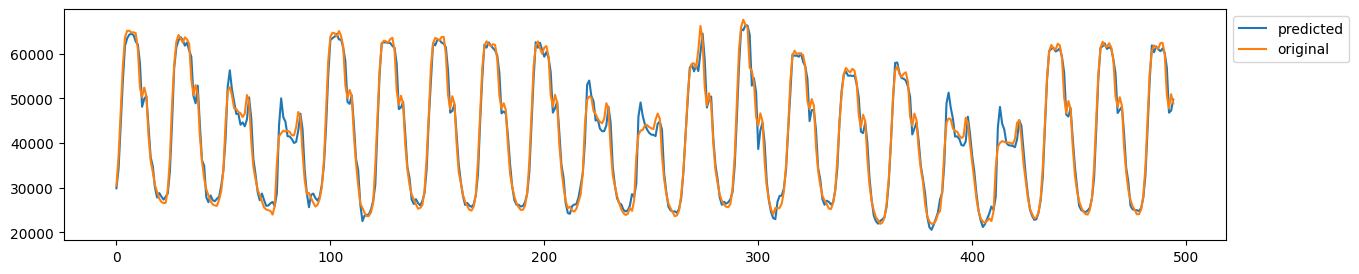

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
ax.plot(y_pred,label='predicted')
ax.plot(test,label='original')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
plt.show()

# Sliding window cross validation

In [ ]:
import math
def cal_nrmse(rmse, y):
    x = max(y)-min(y)
    return (rmse/x)
def sliding_window(data):
  result = {
         "window": [],
         "rmse": [],
         "mape": [],
         "mae": [],
         "nrmse": []

    }
  set_parts = [3,4,5,6,7,8,9,10,20]
  set_orders = [2,3,4,5,6]
  numLayers =2
  orderMax = np.max(set_orders)
  for  count,train, test in Util.sliding_window(data, windowsize=2000, train=0.9, increment_rate=0.2):
    print(f'training window {(count)}')

    estimated_outputs_train = []
    estimated_outputs_test=[]
    for ii in set_parts:
      for jj in set_orders:
        partitioner = Grid.GridPartitioner(data=train, npart=ii, mf=mf.trimf)
        model = FCM_FTS(partitioner=partitioner, order=jj, num_fcms=numLayers,
                      activation_function=Activations.relu,
                      loss=func, orderMax=orderMax)

        aux_train=model.outputEstimation(train)
        aux_test=model.outputEstimation(test)
        estimated_outputs_train = estimated_outputs_train + aux_train

        estimated_outputs_test = estimated_outputs_test + aux_test

    lambdas = trainRegression(train,estimated_outputs_train,orderMax=orderMax, typeRegression='Lasso')
    print(f'lambdas:{(lambdas)}')

    y_pred=lambdas[0]
    for i in range(len(estimated_outputs_test)):
      y_pred=y_pred+lambdas[i+1]*np.array(estimated_outputs_test[i])


    original=test[orderMax:]
    forecast=y_pred
    mae = round(mean_absolute_error(original,forecast),3)
    rmse = round(Measures.rmse(original,forecast),3)
    mape = round(Measures.mape(original,forecast),3)
    nrmse = round(cal_nrmse(rmse, original),3)

    result["rmse"].append(rmse)
    result["nrmse"].append(nrmse)
    result["mape"].append(mape)
    result["mae"].append(mae)
    result["window"].append(count)
  measures = pd.DataFrame(result)
  return measures

In [ ]:
df=pd.read_csv('https://query.data.world/s/e5arbthdytod3m7wfcg7gmtluh3wa5', sep=';')
data = df['load'].values[:8760]
for experiment in range(0,1):
    print('n_experiment is:', experiment)
    result_large_resrevoir =  sliding_window(data=data)


n_experiment is: 0
training window 0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.492e+08, tolerance: 3.528e+07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.492e+08, tolerance: 3.528e+07
  model = cd_fast.enet_coordinate_descent(


resultsCV.alpha_: 223602.36545419728
lambdas:[ 5.74032387e+04  0.00000000e+00 -4.67379909e-01  2.17816324e-01
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -1.12297518e-01  0.00000000e+00  1.05039870e-01
  4.83120350e-01 -8.66824159e-02 -2.29682875e-01 -0.00000000e+00
 -0.00000000e+00  1.45484364e-01  4.44763443e-02  8.45105327e-03
  0.00000000e+00 -0.00000000e+00 -1.10622946e+00 -5.88713418e-02
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  8.57451077e-02
  6.95365583e-02  5.85200926e-02 -6.34272064e-02 -2.46850794e-02
 -5.20303562e-02 -1.40211083e-01 -0.00000000e+00  9.73155151e-02
 -0.00000000e+00  1.05091678e-01  0.00000000e+00  1.52731592e-02
 -0.00000000e+00  0.00000000e+00 -7.59871579e-02  0.00000000e+00
  8.51591605e-02  0.00000000e+00 -0.00000000e+00  3.62391261e-02
 -2.06808048e-02  2.56278979e-02 -4.54897472e-02  1.65019706e-03
  1.15904269e-01  0.00000000e+00  1.61007574e-03 -1.25795125e-01
 -0.00000000e+00 -1.44355243e-02  0.00000000e

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.319e+08, tolerance: 3.582e+07
  model = cd_fast.enet_coordinate_descent(


resultsCV.alpha_: 237253.64160624598


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.319e+08, tolerance: 3.582e+07
  model = cd_fast.enet_coordinate_descent(


lambdas:[ 4.39777008e+03 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.20985139e-02  0.00000000e+00 -5.94720762e-02 -2.30665447e-01
  0.00000000e+00 -0.00000000e+00 -8.86002501e-02  0.00000000e+00
  5.19589673e-01 -0.00000000e+00 -2.42403195e-02  4.34705945e-01
 -1.66967052e-01  4.77034800e-02 -0.00000000e+00 -1.66895703e-01
 -2.61258105e-01  7.20360232e-02 -0.00000000e+00  0.00000000e+00
 -1.12828338e-02  0.00000000e+00 -1.53294734e-01  0.00000000e+00
 -0.00000000e+00  5.00551662e-02  7.47156910e-02 -1.22675469e-01
  3.24190752e-01 -1.03591999e-01  1.91765980e-01  1.65262596e-01
 -3.24817752e-03  0.00000000e+00 -8.24396466e-02  9.99803415e-02
 -6.28328404e-02 -0.00000000e+00 -3.02256545e-04  2.50206422e-01
  0.00000000e+00  3.75953535e-02  1.12985403e-02 -8.02483052e-03
 -1.15051986e-01 -4.61348455e-02  2.75301793e-02  1.58620959e-02
 -1.78265862e-02  0.00000000e+00 -0.00000000e+00  6.65628241e-02
  4.95065759e-02 -7.36234926e-03  1.30204500e-02 -8.30910177e-02
 -3.32216441e-02 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.602e+08, tolerance: 3.801e+07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.602e+08, tolerance: 3.801e+07
  model = cd_fast.enet_coordinate_descent(


resultsCV.alpha_: 213513.23654677867
lambdas:[ 2.05182648e+04  0.00000000e+00 -4.10539584e-01  2.66649106e-01
  0.00000000e+00 -7.93179131e-02 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  7.72317308e-02  3.04825638e-01  3.43842617e-01  7.42556125e-01
 -2.24403116e-01 -7.09636187e-02 -0.00000000e+00  7.44013725e-02
 -2.46649744e-01 -0.00000000e+00  2.51392791e-01 -0.00000000e+00
 -1.66961395e-01 -8.64473391e-02  0.00000000e+00  2.18352199e-02
 -4.07467320e-02 -0.00000000e+00  2.32843221e-01  1.60551152e-01
 -1.99647641e-02 -1.17820315e-02 -7.10860381e-02 -2.41008419e-02
 -4.45807171e-02 -0.00000000e+00  0.00000000e+00 -5.86656571e-02
  1.51219692e-02  0.00000000e+00  0.00000000e+00 -2.24276877e-01
 -2.40969990e-02 -8.41612177e-03 -0.00000000e+00 -3.98738877e-02
 -6.27354300e-02  1.44962118e-01  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  7.59238770e-02 -0.00000000e+00 -0.00000000e+00
 -6.84891229e-02 -0.00000000e+00  0.00000000e

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.444e+08, tolerance: 3.987e+07
  model = cd_fast.enet_coordinate_descent(


resultsCV.alpha_: 204223.72200602817


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.444e+08, tolerance: 3.987e+07
  model = cd_fast.enet_coordinate_descent(


lambdas:[ 3.88309177e+04  4.65841376e-01 -0.00000000e+00  1.86205990e+00
  2.82763696e-02  0.00000000e+00 -0.00000000e+00  2.28649495e-01
 -8.17962661e-01  0.00000000e+00 -0.00000000e+00  1.59612866e-01
  0.00000000e+00 -1.99675953e-01 -0.00000000e+00 -1.38443644e-01
 -0.00000000e+00  2.64929923e-02  3.73608148e-02 -2.99705793e-01
  9.37864757e-02  0.00000000e+00  2.30891440e-01  6.25789236e-02
 -3.08250874e-01 -0.00000000e+00 -0.00000000e+00 -1.28166782e-04
  4.28169140e-01 -0.00000000e+00 -1.77134972e-02 -5.87522009e-01
 -2.55483420e-03  2.20611347e-01  1.46943101e-02  0.00000000e+00
 -2.13150895e-01 -1.01485900e-01  0.00000000e+00 -1.12838544e-02
 -1.54354242e-01  2.68474865e-02  3.01333312e-03 -1.08744223e-01
 -3.55388319e-02  0.00000000e+00 -0.00000000e+00  5.06128479e-02
  4.99896660e-03 -2.24692969e-02  6.75031447e-02 -1.80909976e-02
 -4.95125170e-02 -2.70537670e-01  5.52020399e-03 -3.24015475e-02
  0.00000000e+00  8.01651341e-02  5.93637759e-02  0.00000000e+00
  9.83730004e-03 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.542e+08, tolerance: 3.942e+07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.542e+08, tolerance: 3.942e+07
  model = cd_fast.enet_coordinate_descent(


resultsCV.alpha_: 207664.19702483437
lambdas:[ 6.77839280e+04  4.91294522e-02  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -9.69245454e-02 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  1.80535371e-01  0.00000000e+00 -0.00000000e+00
 -9.76435444e-02 -0.00000000e+00  4.81932538e-01 -0.00000000e+00
 -7.07459481e-01  0.00000000e+00  9.81500126e-03 -1.68903299e-01
  2.59880997e-02 -0.00000000e+00 -2.40331407e-01 -4.44949443e-01
 -4.86025710e-02 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.76388726e-01  7.45707227e-02  6.25513859e-02  2.13615595e-02
 -6.69499648e-02  1.02374249e-01  2.60792560e-01  2.37780087e-02
 -0.00000000e+00 -0.00000000e+00 -3.80269257e-02 -1.09523675e-01
 -8.48936804e-02 -1.49294712e-01 -0.00000000e+00  1.79547132e-01
 -2.74144579e-02 -5.40618318e-01  0.00000000e+00  1.21134613e-01
  5.38635283e-02  0.00000000e+00 -0.00000000e+00 -9.86513484e-02
 -3.69312450e-02 -6.93408732e-02  5.00092973e-02  8.32063757e-02
  0.00000000e+00 -4.21355307e-02  0.00000000e

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.200e+08, tolerance: 3.939e+07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.200e+08, tolerance: 3.939e+07
  model = cd_fast.enet_coordinate_descent(


resultsCV.alpha_: 270411.99797174125
lambdas:[ 4.42217235e+04  0.00000000e+00  9.47027176e-02  0.00000000e+00
  0.00000000e+00 -1.61761997e-01  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -1.62740432e-01  6.02278179e-02 -5.00767162e-01
 -5.65089430e-01  0.00000000e+00  1.88083999e-01  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.09272949e-01
 -9.24994871e-03 -0.00000000e+00 -1.83053032e-02 -0.00000000e+00
  9.14373740e-02  0.00000000e+00 -9.75835302e-02  1.89656742e-02
  2.41467218e-02  1.87037145e-02  7.33160912e-04 -1.84632155e-02
  3.04320481e-01  2.25822219e-01  1.87637757e-02 -8.45209460e-03
  8.22912680e-03  1.39203301e-02 -1.19178737e-01 -0.00000000e+00
  2.50552529e-02  0.00000000e+00 -4.55010643e-02 -1.42295389e-01
  1.16205295e-01  1.10913301e-01 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -4.83038514e-02 -0.00000000e+00 -3.28745617e-02
  4.63945035e-01  7.22445702e-02  0.00000000e+00 -1.38471473e-01
 -0.00000000e+00 -0.00000000e+00 -0.00000000e

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.724e+07, tolerance: 3.841e+07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.724e+07, tolerance: 3.841e+07
  model = cd_fast.enet_coordinate_descent(


resultsCV.alpha_: 207242.4219598642
lambdas:[ 5.38202191e+04  0.00000000e+00  5.55534142e-01  3.83669078e-01
  8.24399515e-02  0.00000000e+00 -0.00000000e+00 -2.09251981e-01
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -2.94673163e-01  1.05946271e-01 -0.00000000e+00  0.00000000e+00
  2.93877911e-02  8.12140226e-03 -1.90538416e-02 -4.40829101e-02
  6.57262764e-02  0.00000000e+00 -1.45293873e-01  5.20903596e-03
  0.00000000e+00  0.00000000e+00  2.62761558e-02  1.48483802e-01
 -1.52964246e-01 -4.76805640e-02 -2.53315104e-01 -1.92690317e-01
  1.46156334e-01  9.70922687e-02 -1.69653527e-01  0.00000000e+00
 -1.81997307e-01  8.75206110e-02  1.23749842e-02 -7.55607536e-02
  1.02473287e-02 -3.09610118e-01 -0.00000000e+00  0.00000000e+00
  3.39178917e-01 -1.07207841e-02 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  3.17523793e-03  0.00000000e+00 -3.00522902e-01
 -0.00000000e+00  2.14485012e-01  1.63650238e-03  8.28173155e-02
 -4.28015745e-02 -0.00000000e+00 -8.52903506e-

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.360e+08, tolerance: 3.734e+07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.360e+08, tolerance: 3.734e+07
  model = cd_fast.enet_coordinate_descent(


resultsCV.alpha_: 210172.91557540817
lambdas:[ 4.64596400e+04 -0.00000000e+00 -0.00000000e+00 -4.62975689e-01
 -0.00000000e+00 -3.95722411e-01  0.00000000e+00 -1.61490505e-01
 -2.27893989e-01 -0.00000000e+00  0.00000000e+00 -2.04302552e-01
 -0.00000000e+00 -0.00000000e+00  1.84285190e-01  0.00000000e+00
 -8.11679329e-02  1.63545958e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.39886746e-01  3.59003707e-01
 -0.00000000e+00  0.00000000e+00 -1.03531679e-01  5.59177699e-02
 -2.04417131e-02  8.94158574e-02  2.39405144e-02  6.30596959e-03
 -8.15923963e-03 -1.27224662e-01  2.56874818e-01  1.01773590e-01
 -5.96174469e-02  4.07061481e-02  3.79025452e-03  1.24633298e-02
  6.99784678e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.19516414e-02  0.00000000e+00 -7.03843413e-03
  2.76360047e-02  4.86309036e-02 -6.88688067e-04 -4.25976689e-02
  1.63947489e-01 -1.30238979e-01  0.00000000e+00 -2.28232258e-02
  0.00000000e+00 -1.46577007e-02 -2.90278271e

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.856e+08, tolerance: 3.690e+07
  model = cd_fast.enet_coordinate_descent(


resultsCV.alpha_: 233923.82098567003


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.856e+08, tolerance: 3.690e+07
  model = cd_fast.enet_coordinate_descent(


lambdas:[ 8.86919487e+02  6.06220005e-01 -4.32708084e-01  0.00000000e+00
 -4.60992635e-02  7.21549326e-02  0.00000000e+00 -0.00000000e+00
 -2.00991731e-01 -2.87986768e-01  0.00000000e+00  0.00000000e+00
  1.88730071e-01 -0.00000000e+00  0.00000000e+00 -8.88585848e-02
  1.03249202e-01  0.00000000e+00 -0.00000000e+00 -9.74878480e-03
  1.31723212e-01 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  2.26113726e-02  2.26124891e-01 -4.72134702e-02
 -3.31899765e-02 -0.00000000e+00 -7.42302822e-02  2.24164613e-01
  0.00000000e+00 -3.18651689e-02  2.25294887e-01  0.00000000e+00
  1.20204144e-01  4.48143263e-03 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  6.01877100e-02 -5.65446750e-02 -6.36284260e-02
  9.78618492e-02 -4.73050466e-02 -0.00000000e+00  2.26371898e-01
  3.97252975e-02  1.38548174e-03 -3.57370272e-02  2.73392336e-01
  0.00000000e+00  1.98188631e-02  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  3.01859260e-02  0.00000000e+00  2.79188804e-02
  0.00000000e+00 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+08, tolerance: 3.651e+07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e+08, tolerance: 3.651e+07
  model = cd_fast.enet_coordinate_descent(


resultsCV.alpha_: 263463.3891381552
lambdas:[ 2.42815014e+04  0.00000000e+00 -7.85034232e-01  0.00000000e+00
  4.77931162e-01  0.00000000e+00  1.18539504e-01 -4.65137362e-02
  2.17212066e-01 -0.00000000e+00 -0.00000000e+00  3.27099292e-02
 -0.00000000e+00  3.17504226e-01 -0.00000000e+00  1.06322332e-01
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.12587525e-01
  0.00000000e+00  1.06295335e-01 -0.00000000e+00 -0.00000000e+00
  2.94193615e-01 -0.00000000e+00  0.00000000e+00 -2.29373547e-01
 -7.01227434e-02  0.00000000e+00  8.48329354e-02 -0.00000000e+00
  2.17083937e-01 -8.33397854e-03 -0.00000000e+00 -0.00000000e+00
 -2.22656688e-01  6.95751171e-02 -9.31247814e-03  1.47193872e-02
  7.28391046e-02 -3.98979688e-02 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -1.08523006e-01 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  2.05954745e-02 -7.78749750e-02
  0.00000000e+00 -5.89668358e-02 -0.00000000e+00  9.05618830e-02
 -1.75839759e-01  1.02770646e-01  1.97307357e-

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.447e+08, tolerance: 3.693e+07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.447e+08, tolerance: 3.693e+07
  model = cd_fast.enet_coordinate_descent(


resultsCV.alpha_: 221380.2773612472
lambdas:[ 6.81597778e+04  9.19920679e-03 -5.31081134e-01 -0.00000000e+00
 -2.39537498e-01 -0.00000000e+00 -1.89100128e-01  2.71785831e-02
  0.00000000e+00 -0.00000000e+00 -3.05896363e-02 -0.00000000e+00
 -2.05083923e-03 -0.00000000e+00  0.00000000e+00  1.12148534e-01
  0.00000000e+00  9.96430757e-02 -0.00000000e+00 -0.00000000e+00
 -2.67553696e-02  4.21219935e-02  2.44111323e-01  1.34649467e-01
  1.87152645e-01 -6.50858826e-02  0.00000000e+00  0.00000000e+00
 -1.20389061e-01  8.30320457e-02  4.04746133e-02  3.61009346e-04
  3.98941531e-02  1.94346200e-01  0.00000000e+00  8.29521819e-02
  0.00000000e+00 -1.58185570e-02 -7.95837834e-02  1.29987777e-01
 -3.58544156e-02 -6.11223244e-02 -2.45234843e-01 -0.00000000e+00
  1.15873183e-02 -1.21148966e-01 -1.05695111e-01 -7.35342496e-02
 -2.50796379e-02 -2.28958718e-01 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.25800329e-01  0.00000000e+00
  0.00000000e+00 -1.07548574e-01 -2.27595870e-

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.982e+07, tolerance: 3.634e+07
  model = cd_fast.enet_coordinate_descent(


resultsCV.alpha_: 222029.11994849148


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.982e+07, tolerance: 3.634e+07
  model = cd_fast.enet_coordinate_descent(


lambdas:[ 1.04951333e+05  0.00000000e+00 -4.84944847e-01  5.48729379e-01
  0.00000000e+00 -0.00000000e+00 -1.00630879e-01 -2.79942857e-01
 -1.89066121e-01  0.00000000e+00  2.80897397e-01 -3.89390238e-01
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  6.23094894e-02  2.15697024e-02  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.89444367e-01
 -2.66882530e-02 -3.52235353e-02  5.76455407e-02 -0.00000000e+00
 -6.20881744e-04  7.47498723e-03 -6.33324414e-03  4.13973916e-02
 -6.25505218e-02  1.74903449e-02 -1.37242798e-01  0.00000000e+00
 -3.91971403e-02 -8.14107852e-03  3.54417630e-02  0.00000000e+00
  1.70735287e-02 -2.09219053e-01 -3.16328247e-02 -1.56060035e-02
 -0.00000000e+00  2.18684153e-02 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  6.29553490e-02  1.69875190e-04 -3.22387924e-01
  3.13215890e-02 -2.49100462e-02 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.95467434e-02
  0.00000000e+00 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.793e+07, tolerance: 3.616e+07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.793e+07, tolerance: 3.616e+07
  model = cd_fast.enet_coordinate_descent(


resultsCV.alpha_: 262027.83802658756
lambdas:[ 7.28347900e+04  0.00000000e+00 -1.88957917e+00 -3.79995565e-02
  0.00000000e+00  1.47348806e-01 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  4.52237830e-01  3.64665235e-02 -0.00000000e+00
  0.00000000e+00  2.06038988e-02  0.00000000e+00  1.03170635e-01
  1.55023347e-01 -2.53777434e-02  8.48527431e-02  0.00000000e+00
 -1.93176643e-01  1.98930703e-01 -1.01644001e-01  8.70448505e-02
  0.00000000e+00 -8.18308749e-03 -1.42417298e-02 -5.36271041e-02
 -1.40663478e-02  0.00000000e+00  0.00000000e+00  8.83736871e-02
 -7.60466192e-02 -1.10162712e-01 -0.00000000e+00  1.74198176e-01
 -1.75354730e-02 -1.03389361e-01 -0.00000000e+00  2.16990678e-02
 -5.20112616e-02 -0.00000000e+00  2.55406079e-03  0.00000000e+00
 -2.39471754e-02 -0.00000000e+00 -2.89196792e-02  0.00000000e+00
 -2.79692766e-02  0.00000000e+00  0.00000000e+00 -6.75878999e-02
  2.49845158e-02 -2.78801436e-02 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -1.22726748e-01  3.55070157e

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.791e+07, tolerance: 3.608e+07
  model = cd_fast.enet_coordinate_descent(


resultsCV.alpha_: 206190.9722085446


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.791e+07, tolerance: 3.608e+07
  model = cd_fast.enet_coordinate_descent(


lambdas:[ 1.11181741e+05 -1.07247016e+00 -5.33278001e-01 -0.00000000e+00
  3.10099797e-01 -6.08562168e-03  0.00000000e+00 -0.00000000e+00
 -4.70972591e-02 -1.76925506e-01  1.78708447e-01  7.87828943e-02
  1.54745543e-01  3.69128021e-02  3.40922189e-01  5.71637071e-02
 -0.00000000e+00  0.00000000e+00  7.34772096e-02  0.00000000e+00
 -0.00000000e+00 -1.11451695e-01  1.27364088e-01  0.00000000e+00
 -3.08388033e-02 -0.00000000e+00  4.93715420e-02 -6.22852237e-02
 -1.82463378e-02 -5.75789133e-02 -8.11152878e-03 -0.00000000e+00
  2.47385154e-02  1.08286673e-01 -0.00000000e+00  7.07742395e-03
 -1.16841514e-01 -6.59901823e-02  0.00000000e+00 -5.46194514e-02
  2.90860568e-02 -6.00918019e-02  1.88215123e-02  0.00000000e+00
 -3.69775286e-02 -7.49751429e-02 -2.43371001e-01  0.00000000e+00
 -1.04070071e-02 -1.76327644e-02  1.46270603e-02  1.67423953e-01
  0.00000000e+00 -0.00000000e+00 -2.70340557e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.72738921e-02 -1.33056130e-02
 -9.69831061e-03 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.560e+08, tolerance: 3.567e+07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.560e+08, tolerance: 3.567e+07
  model = cd_fast.enet_coordinate_descent(


resultsCV.alpha_: 296396.22522601206
lambdas:[ 9.13066519e+04  0.00000000e+00 -0.00000000e+00  2.76347072e-01
 -7.91813882e-01 -3.47262330e-01 -1.88642331e-01  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -6.38433115e-02  5.03808893e-02 -0.00000000e+00
  9.26800182e-02 -0.00000000e+00  0.00000000e+00 -1.59114251e-03
  0.00000000e+00 -7.45912169e-02 -3.04105531e-01  1.01518778e-01
 -2.42792830e-01 -0.00000000e+00  6.29999129e-03 -8.66782355e-02
 -1.40879146e-01  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  2.10444913e-02 -0.00000000e+00 -0.00000000e+00 -6.80229936e-02
 -0.00000000e+00 -5.66573694e-02 -5.11278538e-02  9.59091881e-02
  1.04317006e-02  1.13455132e-01  1.64777170e-01 -1.03604932e-02
 -9.82532922e-02  9.62684297e-02  1.24555587e-02  4.22056317e-02
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -6.36988337e-02
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -3.19269207e-02
 -0.00000000e+00  0.00000000e+00  1.27446812e

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39381434.54809761, tolerance: 28484186.313058246
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52445156.588157654, tolerance: 28484186.313058246
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56435345.881949425, tolerance: 28484186.313058246
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: Convergen

resultsCV.alpha_: 241300.2103126599
lambdas:[ 9.68915623e+04  1.50804580e-01 -0.00000000e+00 -3.96972044e-01
 -8.61141529e-01 -0.00000000e+00 -3.10946041e-01 -0.00000000e+00
  0.00000000e+00 -9.05467230e-02 -4.11114673e-02  5.02932899e-02
  0.00000000e+00 -1.99141712e-01 -1.95006445e-01  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.42688535e-01 -1.69798236e-01 -1.13686741e-01 -7.05222933e-02
  1.51193790e-01 -7.48962828e-02  2.24710928e-01 -3.85182083e-02
 -0.00000000e+00  1.63693266e-01 -8.80816161e-02 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.93818562e-02 -7.50176222e-03
  7.05535848e-02  8.86643489e-02  1.00692804e-01 -0.00000000e+00
  6.96548599e-02  6.89832711e-02  0.00000000e+00 -0.00000000e+00
  1.92133474e-02 -3.35775029e-02 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.02081746e-02 -0.00000000e+00  1.84806814e-

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.722e+08, tolerance: 3.628e+07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.722e+08, tolerance: 3.628e+07
  model = cd_fast.enet_coordinate_descent(


In [ ]:
print(result_large_resrevoir)

    window      rmse   mape       mae  nrmse
0        0  2424.738  3.959  1813.159  0.053
1      200  2415.591  3.729  1743.052  0.049
2      400  2890.560  4.276  2032.557  0.063
3      600  2728.079  4.584  2099.711  0.058
4      800  2716.931  4.226  1892.460  0.058
5     1000  2497.907  4.399  1880.983  0.053
6     1200  2548.441  3.658  1626.816  0.059
7     1400  1654.984  2.768  1211.279  0.038
8     1600  2235.698  3.668  1566.429  0.050
9     1800  2745.560  4.722  1938.378  0.051
10    2000  2215.677  3.312  1518.102  0.049
11    2200  2037.497  3.249  1448.288  0.045
12    2400  1858.577  3.291  1370.928  0.044
13    2600  2035.400  3.559  1493.088  0.047
14    2800  2138.346  3.788  1567.251  0.046
15    3000  2066.206  3.375  1463.432  0.046
16    3200  1791.826  2.962  1306.263  0.042
17    3400  1743.701  2.871  1241.627  0.041
18    3600  1634.179  2.839  1194.032  0.037
19    3800  2657.171  5.193  1924.464  0.062
20    4000  2748.824  5.738  1977.693  0.059
21    4200

In [ ]:
result_large_resrevoir.to_csv('result_large_resrevoir2layers.csv')

In [ ]:
import statistics
final_result = {
     "rmse": [],
     "mae": [],
     "nrmse": [],
    "mape": []
}

measures = result_large_resrevoir

rmse = round(statistics.mean(measures.loc[:,'rmse']),3)
nrmse = round(statistics.mean(measures.loc[:,'nrmse']),3)
mae = round(statistics.mean(measures.loc[:,'mae']),3)
mape = round(statistics.mean(measures.loc[:,'mape']),3)


final_result["rmse"].append(rmse)
final_result["nrmse"].append(nrmse)
final_result["mae"].append(mae)
final_result["mape"].append(mape)



In [ ]:
final=pd.DataFrame(final_result)
print(final)

       rmse       mae  nrmse   mape
0  2132.856  1537.662  0.048  3.624
